In [1]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp
import scipy.optimize as opt
import multiprocessing as mp
from numba import guvectorize
import matplotlib.gridspec as gridspec

In [ ]:
### BIG CATCH ALL NOTEBOOK FOR ANALYSIS OF BETA VS ALPHA SIGNALS ###
# Carried out in Peter Kammel's setup, using degradation foil

In [2]:
# all data taken with 4ns sampling time (250Ms/s)


file1 = "DataR_CH1@DT5725_1146_beta_test.lh5" # path to raw file
file2 = "DataR_CH1@DT5725_1146_betas_only.lh5"
in_ctrl = "DataR_CH1@DT5725_1146_no_beta_ctrl.lh5"
in_ctrl_night = "DataR_CH1@DT5725_1146_no_beta_ctrl_overnight.lh5"

in_a_foil = "DataR_CH1@DT5725_1146_alpha_foil.lh5"
in_b_foil = "DataR_CH1@DT5725_1146_beta_foil.lh5"
in_both_foil = "DataR_CH1@DT5725_1146_both_foil.lh5"

out1 = "beta_out.lh5"
out2 = "beta_only_out.lh5"
out3 = "beta_only_out_moar.lh5"

out_ctrl = "beta_ctrl.lh5"
out_ctrl_night = "beta_ctrl_overnight.lh5"

out_a_foil = "a_foil.lh5"
out_b_foil = "b_foil.lh5"
out_both_foil = "both_foil.lh5"

In [3]:
dsp_config = {
    "outputs": ["bl", "wf_blsub"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            }
    }    
}

In [4]:
dsp_config2 = {
    "outputs": ["bl", "wf_blsub", "wf_pz", "wf_etrap", "trapEftp"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [5]:
def process_data(file, out, config=dsp_config):
    out_path = out
    
  
    build_dsp(
        f_raw=file, 
        f_dsp=out_path,
        lh5_tables = f"CompassEvent",
        dsp_config = config,
        write_mode = 'r'
    )


def process_data2(infile, outfile, rise, flat, pztau, config=dsp_config2):
    dsp_db = {
        "CompassEvent": {
            "pz_tau": f"{pztau}*ms",
            "etrap": {
                "rise": f"{rise}*us",
                "flat": f"{flat}*us"
            },
            "ftp": 1000 + (rise + 0.5*flat)/(0.004)    
        }
    }

    build_dsp(
        f_raw=infile, 
        f_dsp=outfile,
        lh5_tables = "CompassEvent",
        dsp_config = config,
        database = dsp_db,
        write_mode = 'r'
    )
  

In [6]:
####### NECESSARY GLOBAL VARIABLES ########
bins = np.linspace(0, 6000, 1501)         #
binwidth = bins[1] - bins[0]              #
bin_centers = bins[:-1] + binwidth/2      #
adc2e = 5804/4815                         #
###########################################

In [7]:
def select_n_cut(dsp_file):
    f = h5py.File(dsp_file)
    wf_blsub = f['CompassEvent']['wf_blsub']['values'][:]
    f.close()
    #cut_wfs = wf_blsub[:,900:1100]
    #max_heights = np.max(cut_wfs, axis=1)
    max_heights = np.max(wf_blsub, axis=1)
    #max_heights = max_heights[max_heights < 1700]
    #max_heights = max_heights[max_heights > 1000]
    #result = [[max_height, waveform] for max_height, waveform in zip(max_heights, cut_wfs)]
    result = [[max_height, waveform] for max_height, waveform in zip(max_heights, wf_blsub)]
    return result

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Define the fit function 
def fit_func(x, mu, sigma, eta, tau1, tau2):
    return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
                  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))


# Define the cdf of the fit function
def cdf_fit_func(x, A, mu, sigma, eta, tau1, tau2):
    return A * np.cumsum(fit_func(x, mu, sigma, eta, tau1, tau2)) * binwidth


# Iminuit optimizer function takes actual data and returns the optimized fit and params 
def optimizer(counts, gimme_moar=False):
    c = cost.ExtendedBinnedNLL(counts, bins, cdf_fit_func)
    m = Minuit(c, A=10000, mu=600, sigma=5, eta=0.25, tau1=20, tau2=20)
    m.limits["A"] = (2000, 14000)
    m.limits["sigma"] = (0.5,35)
    m.limits["tau1"] = (0.05, 1000)
    m.limits["tau2"] = (0.05, 1000)
    m.limits['eta'] = (0,1)
    var = m.migrad()  # need to call migrad but prob dont need the return variable
    A_fit = m.values['A']
    mean_fit = m.values['mu']
    std_fit = m.values['sigma']
    eta_fit = m.values['eta']
    tau1_fit = m.values['tau1']
    tau2_fit = m.values['tau2']
    fwhm_fit = 2.355*std_fit
    energy_fwhm = fwhm_fit*3271.2/mean_fit
    energy_resolution = fwhm_fit/mean_fit

    minuit_fit = A_fit * fit_func(bins, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)
    if gimme_moar:
        return minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution
    else:
        return minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution


# Plotting function which plots the fit and the data along with some other info
def plot_fit(noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, g_fit_package = False, rise = False, flat = False):
    #plt.plot(x, test_fit, color='green', label='Test Fit', alpha = 0.75)
    plt.hist(noise_cut, bins=bins, color='blue', alpha=0.5)
    plt.plot(bins, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
    if g_fit_package:
        plt.plot(bin_centers, g_fit_package[0], color='black', label='Half-Gaussian Fit')
        plt.text(0.02, 0.55, 'Half-Gaussian Fit Energy_Resolution:' + str(round(g_fit_package[1]*100, 2)) + '%', transform=plt.gca().transAxes)
        plt.text(0.02, 0.6, 'Half-Gaussian Fit Energy_FWHM:' + str(round(g_fit_package[2], 2)) + ' keV', transform=plt.gca().transAxes)
    plt.axvline(mean_fit, color='black', linestyle='--', label='Minuit Mean: ' + str(round(mean_fit, 2)))
    plt.axvline(mean_fit + fwhm_fit/2, color='black', linestyle=':', label='Minuit FWHM: ' + str(round(fwhm_fit, 2)))
    plt.axvline(mean_fit - fwhm_fit/2, color='black', linestyle=':')
    plt.text(0.02, 0.65, 'Minuit Energy Resolution: ' + str(round(energy_resolution*100, 2)) + '%', transform=plt.gca().transAxes)
    plt.text(0.02, 0.7, 'Minuit Energy FWHM: ' + str(round(energy_fwhm, 2)) + ' keV', transform=plt.gca().transAxes)
    plt.xlim(550, 607)

    if rise and flat:
        plt.title(f'Gd-148 Alpha Spectrum [Rise: {rise:.2f}us, Flat: {flat:.2f}us]')
    else:
        plt.title('Gd-148 Alpha Spectrum')
    plt.xlabel('Energy (ADC)')
    plt.ylabel('Counts')
    #plt.ylim(1e-2, 2e2)
    #plt.yscale('log')
    plt.legend()
    #plt.ylim(1e-1, 2e3)
    #plt.yscale('log')
    plt.show()

def plot_heat_map(e_fwhm_array, rises, flats):
    figgy, axs = plt.subplots(figsize=(10, 10))
    im = axs.imshow(e_fwhm_array, origin='lower')
    round_rises = np.around(rises, 2)
    round_flats = np.around(flats, 2)
    axs.set_xticks(np.arange(len(flats)), labels=round_flats)
    axs.set_yticks(np.arange(len(rises)), labels=round_rises)
    plt.setp(axs.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    axs.set_title("Energy Resolution vs Rise and Flat Times")
    axs.set_xlabel("Flat Time (us)")
    axs.set_ylabel("Rise Time (us)")
    plt.colorbar(im)
    figgy.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.show()


In [8]:
def fit_half_gauss(data, walk, gimme_all=False):
    counts, _ = np.histogram(data, bins=bins)
    max_counts = np.max(counts)
    max_index = np.argmax(counts)
    walk_left = max_index - walk
    e_left = bins[walk_left]                
    cut_counts = counts[walk_left:]
    cut_data = data[data > e_left]
    x = bin_centers[walk_left:]
    popt, pcov = opt.curve_fit(gaussian, x, cut_counts, p0=[max_counts, bin_centers[max_index], 5])
    mean_temp = popt[1]
    stdev_temp = popt[2]
    e_res_temp = stdev_temp*2.355/mean_temp
    if gimme_all:
        return e_res_temp, popt, cut_data, cut_counts, x, counts, max_index, walk_left, e_left, max_counts
    else:
        return e_res_temp, popt

In [9]:
a_data = select_n_cut(out_a_foil)
b_data = select_n_cut(out_b_foil)
both_data = select_n_cut(out_both_foil)

In [10]:
ctrl_data = select_n_cut(out_ctrl_night)

In [11]:
# returns list like this:    list[range][event_index][max or wf]

def classifier(maxes, wfs, ranges, wantmax = False):
    beepboop = []
    for range in ranges:
        list = []
        for i, max in enumerate(maxes):
            if max >= range[0] and max <= range[1]:
                if wantmax:
                    list.append((max,wfs[i]))
                else:
                    list.append(wfs[i])
        beepboop.append(list)
    return beepboop
                


In [12]:
def make_ranges(start, stop, step):
    ranges = []
    numline = np.arange(start, stop+step, step)
    for i in range(len(numline)-1):
        ranges.append((numline[i], numline[i+1]))
    return ranges, numline


def analyze_spike_inator(maxes, wfs, start, stop, step):
    ranges, numline = make_ranges(start, stop, step)
    classified_wfs = classifier(maxes, wfs, ranges)
    print(ranges)
    average_diffs = []
    superpulses = []        #maybe need later
    for wf_blsub in classified_wfs:
        if len(wf_blsub) == 0:
            superpulses.append(0)
            average_diffs.append(0)
        else:
            wfs_norm = wf_blsub/np.max(wf_blsub, axis=1)[:,None]
            super_wf_blsub = np.average(wfs_norm, axis=0)
            superpulses.append(super_wf_blsub)

            residuals = super_wf_blsub[None,:] - wfs_norm
            absdiff = np.abs(residuals)
            sumdiff = np.sum(absdiff, axis=1)
            average_diff = np.average(sumdiff)
            average_diffs.append(average_diff)

    return numline, ranges, average_diffs
    
    

In [13]:
a_maxes = [item[0] for item in a_data]
a_wfs = [item[1] for item in a_data]

b_maxes = [item[0] for item in b_data]
b_wfs = [item[1] for item in b_data]

both_maxes = [item[0] for item in both_data]
both_wfs = [item[1] for item in both_data]

ctrl_maxes = [item[0] for item in ctrl_data]
ctrl_wfs = [item[1] for item in ctrl_data]

In [14]:
# wfs and maxes have corresponding indices in the list so this just scales energy and not wfs but the maxes still correspond to the same wfs

b_maxes_e = np.array(b_maxes)*adc2e
a_maxes_e = np.array(a_maxes)*adc2e
c_maxes_e = np.array(ctrl_maxes)*adc2e

Text(0, 0.5, 'Counts')

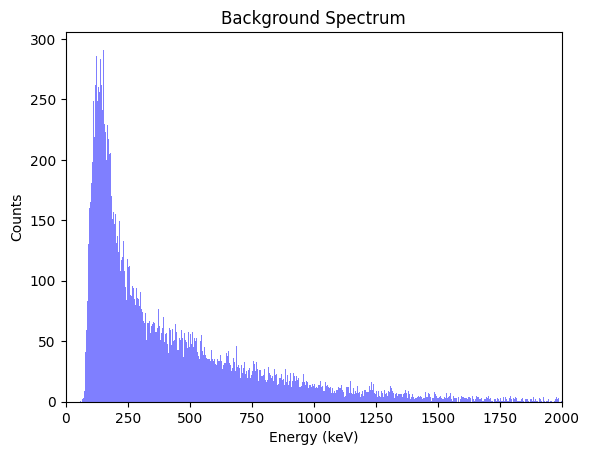

In [15]:
plt.hist(c_maxes_e, bins=bins, color='blue', alpha=0.5)
plt.xlim(0,2000)
plt.title('Background Spectrum')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0.5, 80.7222222222222, 'Energy (keV)')

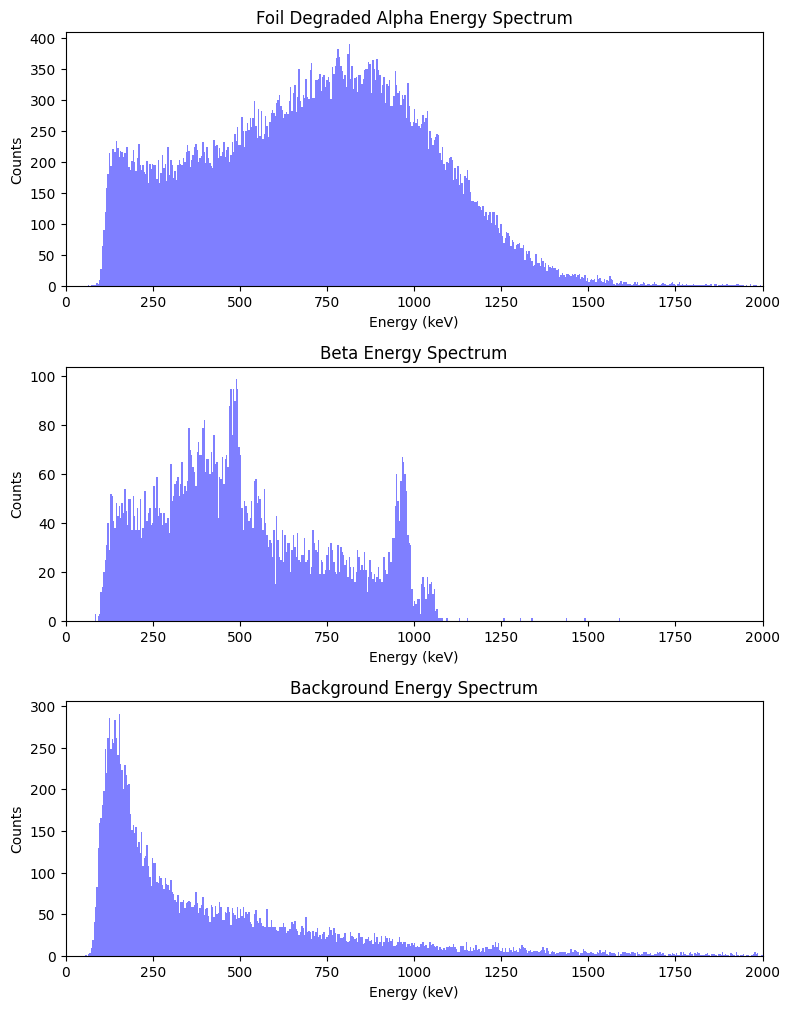

In [83]:
fig, axs = plt.subplots(3, 1, figsize=(8, 10))
axs[0].hist(a_maxes_e, bins=bins, color='blue', alpha=0.5, label='Foil Degraded Alphas')
axs[0].set_title('Foil Degraded Alpha Energy Spectrum')
#axs[0].axvline(575, color='black', linestyle='--', label='Range of Interest: 575-925 keV')
#axs[0].axvline(925, color='black', linestyle='--')
#axs[0].axhline(125, color='green', linestyle='-', label='noise peak')
#axs[0].axhline(210, color='red', linestyle='-', label='roi1 alpha peak')
#axs[0].axhline(190, color='black', linestyle='-', label='roi2 alpha peak')
#axs[0].legend()
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Energy (keV)')
axs[0].set_xlim(0,2000)

b_counts, _, _ = axs[1].hist(b_maxes_e, bins=bins, color='b', alpha=0.5, label='Betas')
axs[1].set_title('Beta Energy Spectrum')
#axs[1].axvline(575, color='black', linestyle='--', label='Range of Interest: 575-925 keV')
#axs[1].axvline(925, color='black', linestyle='--')

#axs[1].axhline(25, color='green', linestyle='-', label='noise peak')
#axs[1].axhline(12, color='red', linestyle='-', label='roi1 beta peak')
#axs[1].axhline(30, color='black', linestyle='-', label='roi2 beta peak')
#axs[1].legend()
axs[1].set_ylabel('Counts')
axs[1].set_xlabel('Energy (keV)')
axs[1].set_xlim(0,2000)

'''
both_counts, _, _ = axs[2].hist(both_maxes, bins=bins, color='green', alpha=0.5, label='Both Foil')
axs[2].set_title('Both Foil Energy Spectrum')
axs[2].axvline(825, color='black', linestyle='--')
axs[2].axvline(775, color='black', linestyle='--')

axs[2].legend()
'''
ctrl_counts, _, _ = axs[2].hist(c_maxes_e, bins=bins, color='b', alpha=0.5, label='Background')
axs[2].set_title('Background Energy Spectrum')
#axs[2].axvline(575, color='black', linestyle='--', label='Range of Interest: 575-925 keV')
#axs[2].axvline(925, color='black', linestyle='--')
#axs[2].legend()
axs[2].set_ylabel('Counts')

plt.tight_layout()

plt.xlim(0,2000)
plt.xlabel('Energy (keV)')



Text(0.5, 0, 'Energy (keV)')

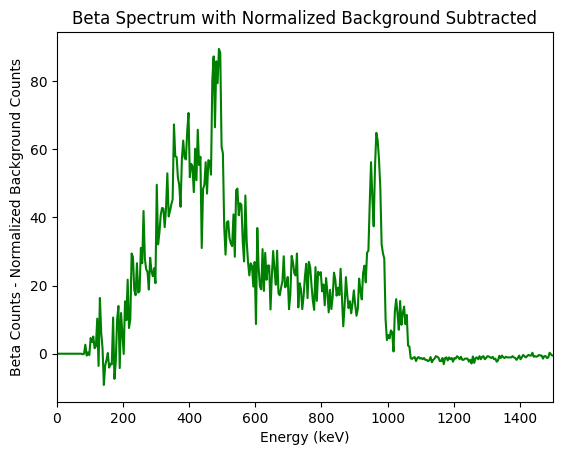

In [70]:
shift = 5
shift_ctrl = np.append(np.zeros(shift),0.18*ctrl_counts[:-shift])
#plt.plot(bin_centers, b_counts, color='blue', label='Beta Spectrum')
#plt.plot(bin_centers, shift_ctrl, color='red', label='Alpha Spectrum')
sub = b_counts - shift_ctrl
plt.plot(bin_centers, sub, color='green', label='Beta - Background')
plt.xlim(0,1500)
plt.title('Beta Spectrum with Normalized Background Subtracted')
plt.ylabel('Beta Counts - Normalized Background Counts')
plt.xlabel('Energy (keV)')

In [71]:
a_classed = classifier(a_maxes_e, a_wfs, [(575,925), (850,925)], wantmax=True)
b_classed = classifier(b_maxes_e, b_wfs, [(575,925), (850,925)], wantmax=True)
ctrl_classed = classifier(c_maxes_e, ctrl_wfs, [(575,925), (850,925)], wantmax=True)

In [84]:
print(f"a classed len: {len(a_classed)}")
print(f"b classed len: {len(b_classed)}")
print(f"ctrl classed len: {len(ctrl_classed)}")
print(f"len a classed roi1: {len(a_classed[0])}")
print(f"len a classed roi2: {len(a_classed[1])}")
print(f"len b classed roi1: {len(b_classed[0])}")
print(f"len b classed roi2: {len(b_classed[1])}")
print(f"len ctrl classed roi1: {len(ctrl_classed[0])}")
print(f"len ctrl classed roi2: {len(ctrl_classed[1])}")


a classed len: 2
b classed len: 2
ctrl classed len: 2
len a classed roi1: 28259
len a classed roi2: 6344
len b classed roi1: 2216
len b classed roi2: 374
len ctrl classed roi1: 2333
len ctrl classed roi2: 353


In [85]:
a_class_wfs_roi1 = [item[1] for item in a_classed[0]]
b_class_wfs_roi1 = [item[1] for item in b_classed[0]]
a_class_wfs_roi2 = [item[1] for item in a_classed[1]]
b_class_wfs_roi2 = [item[1] for item in b_classed[1]]

c_class_wfs_roi1 = [item[1] for item in ctrl_classed[0]]
c_class_wfs_roi2 = [item[1] for item in ctrl_classed[1]]

a_maxi_roi1 = [item[0] for item in a_classed[0]]
b_maxi_roi1 = [item[0] for item in b_classed[0]]
a_maxi_roi2 = [item[0] for item in a_classed[1]]
b_maxi_roi2 = [item[0] for item in b_classed[1]]

c_maxi_roi1 = [item[0] for item in ctrl_classed[0]]
c_maxi_roi2 = [item[0] for item in ctrl_classed[1]]

super_a_wfs_roi1 = np.average(a_class_wfs_roi1/np.max(a_class_wfs_roi1, axis=1)[:,None], axis=0)
super_b_wfs_roi1 = np.average(b_class_wfs_roi1/np.max(b_class_wfs_roi1, axis=1)[:,None], axis=0)
super_a_wfs_roi2 = np.average(a_class_wfs_roi2/np.max(a_class_wfs_roi2, axis=1)[:,None], axis=0)
super_b_wfs_roi2 = np.average(b_class_wfs_roi2/np.max(b_class_wfs_roi2, axis=1)[:,None], axis=0)
super_c_wfs_roi1 = np.average(c_class_wfs_roi1/np.max(c_class_wfs_roi1, axis=1)[:,None], axis=0)
super_c_wfs_roi2 = np.average(c_class_wfs_roi2/np.max(c_class_wfs_roi2, axis=1)[:,None], axis=0)

(0.0, 1000.0)

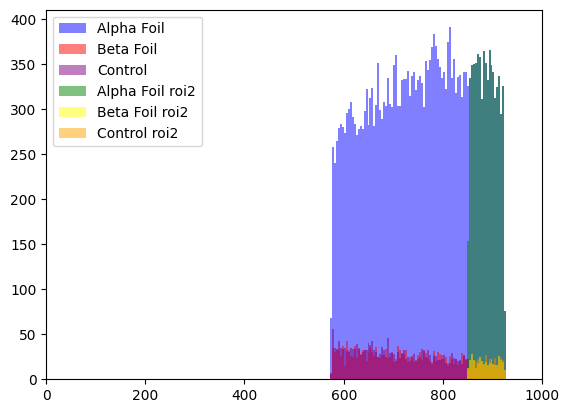

In [86]:
plt.hist(a_maxi_roi1, bins=bins, color='blue', alpha=0.5, label='Alpha Foil')
plt.hist(b_maxi_roi1, bins=bins, color='red', alpha=0.5, label='Beta Foil')
plt.hist(c_maxi_roi1, bins=bins, color='purple', alpha=0.5, label='Control')
plt.hist(a_maxi_roi2, bins=bins, color='green', alpha=0.5, label='Alpha Foil roi2')
plt.hist(b_maxi_roi2, bins=bins, color='yellow', alpha=0.5, label='Beta Foil roi2')
plt.hist(c_maxi_roi2, bins=bins, color='orange', alpha=0.5, label='Control roi2')

plt.legend()

plt.xlim(0,1000)

In [87]:
# Noise / Total Signal Ratios #
n2t_a_roi1 = 1.40458585E-03
n2t_a_roi2 = 9.46677095E-04
n2t_b_roi1 = 5.92760878E-03
n2t_b_roi2 = 5.31419704E-03

# Total Signal / Desired Signal Ratios #

t2d_a_roi1 = 1.0/(1.0 - n2t_a_roi1)
t2d_a_roi2 = 1.0/(1.0 - n2t_a_roi2)
t2d_b_roi1 = 1.0/(1.0 - n2t_b_roi1)
t2d_b_roi2 = 1.0/(1.0 - n2t_b_roi2)

print(f"t2d_a_roi1: {t2d_a_roi1}")
print(f"t2d_a_roi2: {t2d_a_roi2}")
print(f"t2d_b_roi1: {t2d_b_roi1}")
print(f"t2d_b_roi2: {t2d_b_roi2}")


t2d_a_roi1: 1.001406561486361
t2d_a_roi2: 1.0009475741417357
t2d_b_roi1: 1.005962954843485
t2d_b_roi2: 1.0053425886085696


In [88]:
def jane_remover(superpulse, noise_superpulse, t2d, n2t):
    return (superpulse - noise_superpulse*n2t) * t2d


In [89]:
alpha_1 = jane_remover(super_a_wfs_roi1, super_c_wfs_roi1, t2d_a_roi1, n2t_a_roi1)
alpha_2 = jane_remover(super_a_wfs_roi2, super_c_wfs_roi2, t2d_a_roi2, n2t_a_roi2)
beta_1 = jane_remover(super_b_wfs_roi1, super_c_wfs_roi1, t2d_b_roi1, n2t_b_roi1)
beta_2 = jane_remover(super_b_wfs_roi2, super_c_wfs_roi2, t2d_b_roi2, n2t_b_roi2)

(950.0, 1100.0)

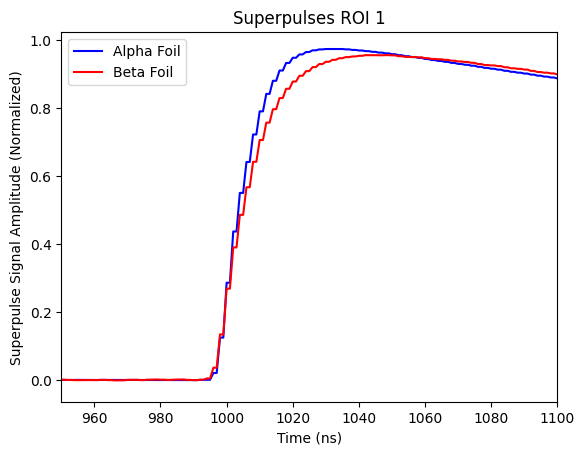

In [90]:
plt.plot(super_a_wfs_roi1, color='blue', label='Alpha Foil')
plt.plot(super_b_wfs_roi1, color='red', label='Beta Foil')
#plt.plot(super_c_wfs_roi1, color='purple', label='Control')
plt.legend()
plt.title('Superpulses ROI 1')
plt.ylabel('Superpulse Signal Amplitude (Normalized)')
plt.xlabel('Time (ns)')
plt.xlim(950, 1100)


(950.0, 1100.0)

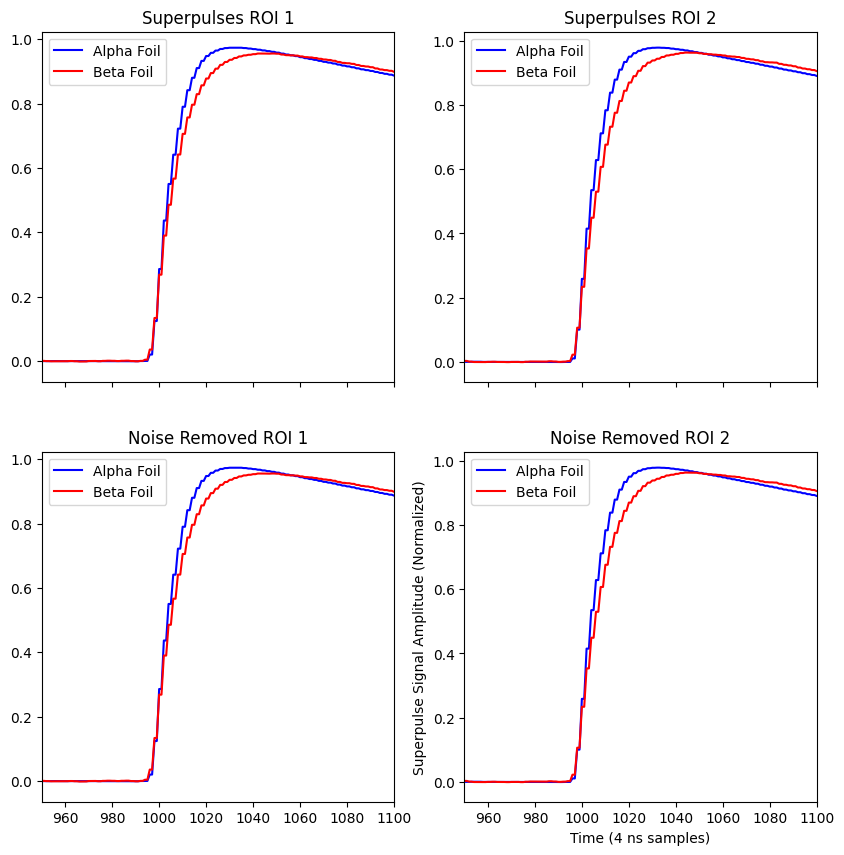

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
axs[0][0].plot(super_a_wfs_roi1, color='blue', label='Alpha Foil')
axs[0][0].plot(super_b_wfs_roi1, color='red', label='Beta Foil')
#axs[0][0].plot(super_c_wfs_roi1, color='purple', label='Control')
axs[0][0].legend()
axs[0][0].set_title('Superpulses ROI 1')

axs[0][1].plot(super_a_wfs_roi2, color='blue', label='Alpha Foil')
axs[0][1].plot(super_b_wfs_roi2, color='red', label='Beta Foil')
#axs[0][1].plot(super_c_wfs_roi2, color='purple', label='Control')
axs[0][1].legend()
axs[0][1].set_title('Superpulses ROI 2')

axs[1][0].plot(alpha_1, color='blue', label='Alpha Foil')
axs[1][0].plot(beta_1, color='red', label='Beta Foil')
axs[1][0].legend()
axs[1][0].set_title('Noise Removed ROI 1')

axs[1][1].plot(alpha_2, color='blue', label='Alpha Foil')
axs[1][1].plot(beta_2, color='red', label='Beta Foil')
axs[1][1].legend()
axs[1][1].set_title('Noise Removed ROI 2')

plt.ylabel('Superpulse Signal Amplitude (Normalized)')
plt.xlabel('Time (4 ns samples)')
plt.xlim(950, 1100)

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 82

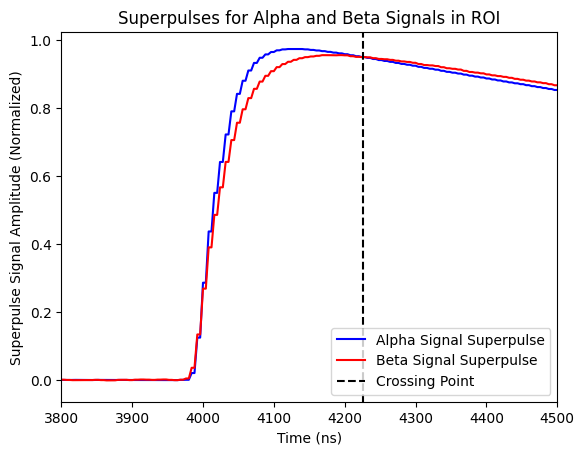

In [98]:
timeline = []
for i in range(len(alpha_1)):
    timeline.append(i*4)

print(timeline)
'''
fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

axs[0].plot(timeline, alpha_1, color='blue', label='Alpha Signal Superpulse')
axs[0].plot(timeline, beta_1, color='red', label='Beta Signal Superpulse')
axs[0].set_ylabel('Superpulse Signal Amplitude (Normalized)')
axs[0].legend()

axs[1].plot(timeline, alpha_2, color='blue', label='Alpha Signal Superpulse')
axs[1].plot(timeline, beta_2, color='red', label='Beta Signal Superpulse')
axs[1].set_ylabel('Superpulse Signal Amplitude (Normalized)')
axs[1].legend()

fig.suptitle('Superpulses for Alpha and Beta Signals')

'''

plt.plot(timeline, alpha_1, color='blue', label='Alpha Signal Superpulse')
plt.plot(timeline, beta_1, color='red', label='Beta Signal Superpulse')
plt.ylabel('Superpulse Signal Amplitude (Normalized)')
plt.xlim(3800,4500)
plt.axvline(4226, color='black', linestyle='--', label='Crossing Point')
#plt.tight_layout()
plt.xlabel('Time (ns)')
plt.title('Superpulses for Alpha and Beta Signals in ROI')
plt.legend()

In [26]:
# need to already have a numpy array ready for the output 
# tau passed to func in ms
@guvectorize(["(float32[:], float32, float32[:])"], "(n),()->(n)", nopython=True)
def polezero(w_in: np.ndarray, tau: float, w_out: np.ndarray):
    tau = tau * 1e6 # convert from ms to ns
    tau = tau / 2  # convert from ns to 2ns samples
    const = np.exp(-1 / tau)
    w_out[0] = w_in[0]
    for i in range(1, len(w_in), 1):
        w_out[i] = w_out[i - 1] + w_in[i] - w_in[i - 1] * const



@guvectorize(
    [
        "void(float32[:], float32, float32, float32, float32[:])",
        "void(float64[:], float64, float64, float64, float64[:])",
    ],
    "(n),(),(),()->(n)",
)

def double_pole_zero(
    w_in: np.ndarray, t_tau1: float, t_tau2: float, frac: float, w_out: np.ndarray
    ) -> np.ndarray:

    t_tau1 = t_tau1 * 1e6 # convert from ms to ns
    t_tau1 = t_tau1 / 2  # convert from ns to 2ns samples
    t_tau2 = t_tau2 * 1e6
    t_tau2 = t_tau2 / 2

    w_out[:] = np.nan

    if np.isnan(w_in).any() or np.isnan(t_tau1) or np.isnan(t_tau2) or np.isnan(frac):
        return
    if len(w_in) <= 3:
        raise Exception(
            "The length of the waveform must be larger than 3 for the filter to work safely"
        )

    a = np.exp(-1 / t_tau1)
    b = np.exp(-1 / t_tau2)

    transfer_denom_1 = frac * b - frac * a - b - 1
    transfer_denom_2 = -1 * (frac * b - frac * a - b)
    transfer_num_1 = -1 * (a + b)
    transfer_num_2 = a * b

    # Create a buffer of float64s, because performing the recursion at float32 causes instabilities in the filter due to truncation
    w_tmp = np.zeros(3, dtype=np.float64)

    # Initialize the arrays for recursion
    w_tmp[0] = w_in[0]
    w_tmp[1] = w_in[1]

    w_out[0] = w_in[0]
    w_out[1] = w_in[1]

    for i in range(2, len(w_in), 1):
        w_tmp[2] = (
            w_in[i]
            + transfer_num_1 * w_in[i - 1]
            + transfer_num_2 * w_in[i - 2]
            - transfer_denom_1 * w_tmp[1]
            - transfer_denom_2 * w_tmp[0]
        )

        w_out[i] = w_tmp[2]  # Put the higher precision buffer into the desired output
        # Shuffle the buffer for the next iteration
        w_tmp[0] = w_tmp[1]
        w_tmp[1] = w_tmp[2]
    # Check the output
    if np.isnan(w_out).any():
        raise Exception("Double-pole-zero filter produced nans in output.")

In [299]:
def dpz_workhorse(input_waveform, tau1, tau2, frac, want_pz1=False):
    my_wf_dpz = np.zeros(len(input_waveform))
    double_pole_zero(input_waveform, tau1, tau2, frac, my_wf_dpz)
    if want_pz1:
        my_wf_pz1 = np.zeros(len(input_waveform))
        polezero(input_waveform, tau1, my_wf_pz1)
        return my_wf_pz1, my_wf_dpz
    else:
        return my_wf_dpz


def dpz_viz_optimizer(input_waveform, tau1s, tau2s, fracs):
    dim1, dim2, dim3 = len(tau1s), len(tau2s), len(fracs)
    fig, axs = plt.subplots(dim1*dim2, dim3, figsize=(5*dim3, 10*dim1*dim2), sharex=True)
    t1list = []
    for i, tau1 in enumerate(tau1s):
        t2list = []
        for j, tau2 in enumerate(tau2s):
            flist = []
            for k, frac in enumerate(fracs):
                my_wf_dpz = dpz_workhorse(input_waveform, tau1, tau2, frac)
                flist.append([[frac, tau1, tau2], my_wf_dpz])
                #axs[(j*dim1)+i][k].plot(my_wf_pz1, label=f'PZ_1')
                axs[(j*dim1)+i][k].plot(my_wf_dpz, label=f'DPZ tau1:{round(tau1, 5)}, tau2:{round(tau2, 5)}, frac:{round(frac, 5)}')
                axs[(j*dim1)+i][k].plot(input_waveform, label='Original')
                axs[(j*dim1)+i][k].legend()

            t2list.append(flist)
        t1list.append(t2list)
    #plt.tight_layout()
    plt.xlim(980,1050)
    return t1list    


def sqr_variance(data, function):
    residuals = data - function
    return np.sum(residuals**2)


def cost_func(pz, raw, weight, ranges, desired_func='flattop', leading_edge_sensitivity = False, save_wfs = False):
    leadingedge = raw[ranges[0]:ranges[1]]
    leadingedge_pz = pz[ranges[0]:ranges[1]]
    afterslice_pz = pz[ranges[1]:ranges[2]]
    afterslice_max = np.max(afterslice_pz)

    if desired_func == 'flattop':                  # this is optimizing for a desired step function signal
        funky = np.full_like(pz, afterslice_max)
        funky_kong = np.full_like(afterslice_pz, afterslice_max)
    elif desired_func == 'linear decay':            # this is optimizing for a desired linear decay signal (maybe signal has third super long pole?)
        lastval = afterslice_pz[-1]
        funky_kong = np.linspace(afterslice_max, lastval, len(afterslice_pz))
        slope = (lastval-afterslice_max)/(len(afterslice_pz)-1)
        ext_range = (slope*(-ranges[1]) + funky_kong[0], slope*((len(pz)-1)-ranges[2])) 
        funky = np.linspace(ext_range[0], ext_range[1], len(pz))


    if leading_edge_sensitivity:
        cost = weight*sqr_variance(leadingedge_pz, leadingedge) + (1-weight)*sqr_variance(afterslice_pz, funky_kong)
        tot_range = ranges[2] - ranges[0]
    else:
        cost = sqr_variance(afterslice_pz, funky_kong)
        tot_range = ranges[2] - ranges[1]

    cost/tot_range * 1000

    if save_wfs:
        return cost, leadingedge_pz, leadingedge, afterslice_pz, funky
    else:
        return cost

def diy_dpz_slice_optimizer(input_waveform, tau1s, tau2s, fracs, ranges, desired_func='flattop', leading_edge_sensitivity = False):
    dim1, dim2, dim3 = len(tau1s), len(tau2s), len(fracs)
    #heatmap = np.empty((dim3, dim1, dim2))
    beeg_list = []
    for k, frac in enumerate(fracs):
        heatmap = np.empty((dim1, dim2))
        best_cost = np.inf
       #best_fit = []
        for i, tau1 in enumerate(tau1s):
            for j, tau2 in enumerate(tau2s):
                my_wf_dpz = dpz_workhorse(input_waveform, tau1, tau2, frac)
                cost, leadingedge_pz, leadingedge, afterslice_pz, funky = cost_func(my_wf_dpz, input_waveform, 0.5, ranges, desired_func, leading_edge_sensitivity, save_wfs=True)
                heatmap[i,j] = cost
                if cost < best_cost:
                    best_cost = cost
                    best_fit = [(tau1, tau2, frac), best_cost, leadingedge_pz, leadingedge, afterslice_pz, funky, my_wf_dpz]
        beeg_list.append([heatmap, best_fit])
        
    return beeg_list 


def plot_all_data(input_waveform, beeg_list, tau1s, tau2s, fracs):
    figgy = plt.figure(figsize=(15, 3*len(fracs)))
    gs = gridspec.GridSpec(len(fracs), 3, width_ratios=[1, 1, 0.05], wspace=0.1, hspace=1)
    
    # Find the min and max values for the color scale
    vmin = np.inf
    vmax = 0    

    axs = []
    for i in range(len(fracs)):
        cost_array = beeg_list[i][0]
        best_fit = beeg_list[i][1]
        params = best_fit[0]
        best_cost = best_fit[1]
        leadingedge_pz = best_fit[2]
        leadingedge = best_fit[3]
        afterslice_pz = best_fit[4]
        funky = best_fit[5]
        my_wf_dpz = best_fit[6]

        vmin = min(vmin, np.min(cost_array))
        vmax = max(vmax, np.max(cost_array))

        ax0 = figgy.add_subplot(gs[i, 0])
        #ax0.plot(leadingedge_pz, label='Leading Edge PZ')
        #ax0.plot(leadingedge, label='Leading Edge Raw')
        #ax0.plot(afterslice_pz, label='After Slice PZ')
        ax0.plot(funky, label='Desired Function')
        ax0.plot(my_wf_dpz, label='DPZ')
        ax0.plot(input_waveform, label='Raw')   
        #ax0.legend()
        ax0.set_title(f"Best Fit: {np.around(params,3)}, Cost: {round(best_cost,3)}")
        ax0.set_xlabel("Time (4 ns samples)")
        ax0.set_ylabel("Amplitude (Normalized)")
        #ax0.set_xlim(975, 1050)


        ax1 = figgy.add_subplot(gs[i, 1])
        im = ax1.imshow(cost_array, origin='lower', vmin=vmin, vmax=vmax)
        ax1.set_xticks(np.arange(cost_array.shape[0]))
        ax1.set_yticks(np.arange(cost_array.shape[1]))
        ax1.set_yticklabels(np.around(tau2s))
        ax1.set_xticklabels(np.around(tau1s, 4), rotation=45, ha="right", rotation_mode="anchor")
        ax1.set_title(f"Frac: {round(fracs[i], 3)}")
        ax1.set_xlabel("tau1")
        ax1.set_ylabel("tau2")



        
        axs.append((ax0,ax1)) ###
    
    # Create a single color bar for all subplots
    cbar_ax = figgy.add_subplot(gs[:, 2])
    cbar = figgy.colorbar(im, cax=cbar_ax)
    cbar.set_label('Cost')
    
    #figgy.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle
    figgy.suptitle("Cost vs. Tau1 and Tau2", fontsize=16, x=0.5)
    plt.show()



def plot_just_wfs(input_waveform, beeg_list, tau1s, tau2s, fracs):
    figgy = plt.figure(figsize=(15, 8*len(fracs)))
    gs = gridspec.GridSpec(len(fracs), 1, wspace=0.1, hspace=0.5)
    
    axs = []
    for i in range(len(fracs)):
        best_fit = beeg_list[i][1]
        params = best_fit[0]
        best_cost = best_fit[1]
        leadingedge_pz = best_fit[2]
        leadingedge = best_fit[3]
        afterslice_pz = best_fit[4]
        funky = best_fit[5]
        my_wf_dpz = best_fit[6]

        ax0 = figgy.add_subplot(gs[i, 0])
        #ax0.plot(leadingedge_pz, label='Leading Edge PZ')
        #ax0.plot(leadingedge, label='Leading Edge Raw')
        #ax0.plot(afterslice_pz, label='After Slice PZ')
        ax0.plot(funky, label='Desired Function')
        ax0.plot(my_wf_dpz, label='DPZ')
        ax0.plot(input_waveform, label='Raw')   
        ax0.legend()
        ax0.set_title(f"Best Fit: {np.around(params,5)}, Cost: {round(best_cost,3)}")
        ax0.set_xlabel("Time (4 ns samples)")
        ax0.set_ylabel("Amplitude (Normalized)")
        #ax0.set_xlim(975, 1050)
        ax0.set_xlim(950,3000)
        axs.append(ax0) ###
    
    plt.show()

In [305]:
tau1s = np.linspace(0.0001, 0.001, 100)
tau2s = np.linspace(0.001, 0.01, 100)
fracs = np.linspace(0.1, 0.9, 18)  

In [306]:
beeg_list = diy_dpz_slice_optimizer(alpha_1, tau1s, tau2s, fracs, (950,1100,3000))
#print(heatmap.shape)

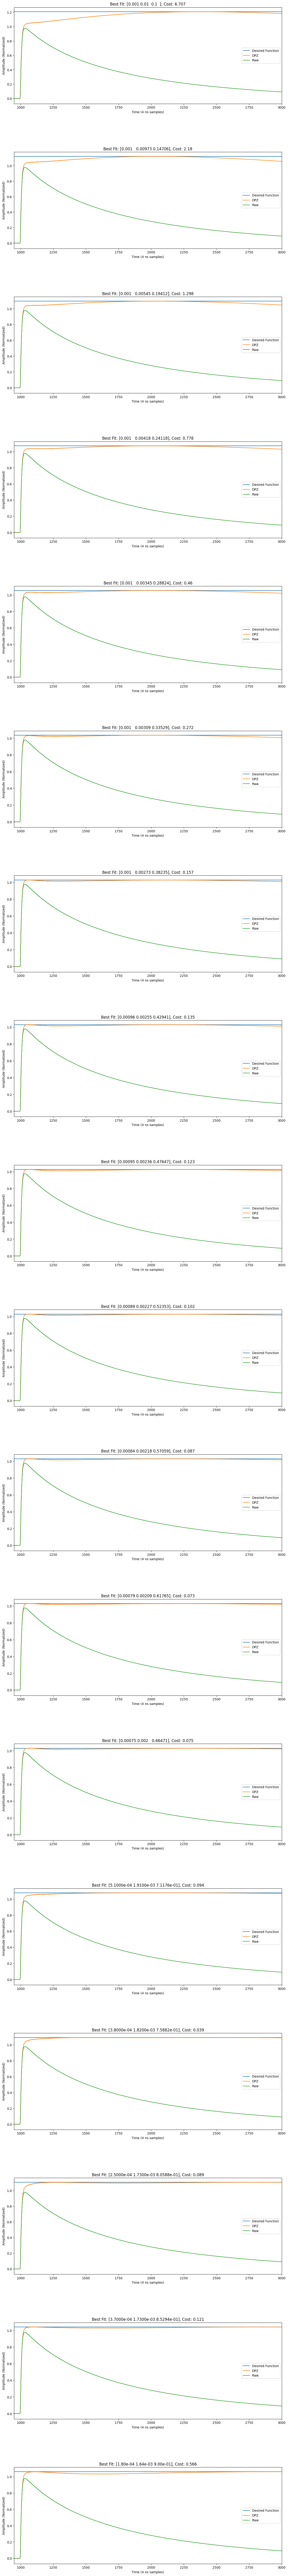

In [307]:
#plot_all_data(alpha_1, beeg_list, tau1s, tau2s, fracs)
plot_just_wfs(alpha_1, beeg_list, tau1s, tau2s, fracs)

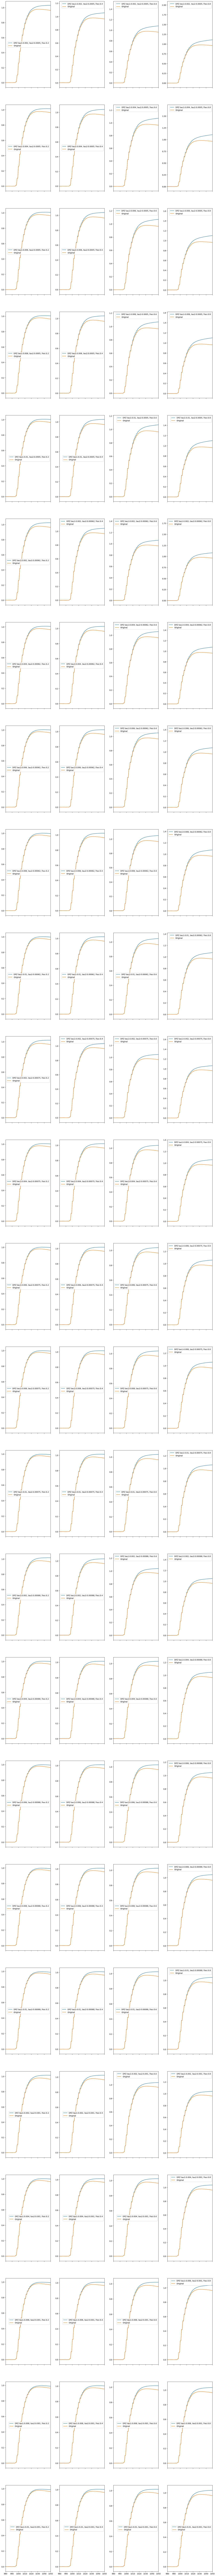

In [47]:
biglist = dpz_viz_optimizer(alpha_1, np.linspace(0.002, 0.01, 5), np.linspace(0.0005, 0.001, 5), np.linspace(0.2, 0.8, 4))

In [39]:
tau1 = 0.0015
tau2 = 0.001
frac = 0.4


#my_wf_pz2 = np.zeros(len(my_wf_pz1))
#polezero(super_wf_blsub, tau2, my_wf_pz2)
#sum_my_wf_pz = (1-frac)*my_wf_pz1 + frac*my_wf_pz2
#
#my_wf_dpz = np.zeros(len(super_wf_blsub))
#double_pole_zero(super_wf_blsub, tau1, tau2, frac, my_wf_dpz)

plt.plot(my_wf_pz1, label="pz corrected")
plt.plot(my_wf_dpz, label="my dpz")
plt.plot(alpha_1, label="original")
#plt.plot(alpha_1, label="original")
#plt.plot(my_wf_pz1, label="pz corrected")
#plt.plot(my_wf_dpz, label="my dpz")
#plt.plot(my_wf_pz1, label='pz1')
#plt.plot(my_wf_pz2, label='pz2')
#plt.plot(sum_my_wf_pz, label='sum')
plt.xlabel("Time [4ns samples]")
plt.legend()
#plt.yscale('log')
#plt.ylim(1e-11, 1.5e0)
#plt.xlim(950, 1100)


NameError: name 'my_wf_pz1' is not defined

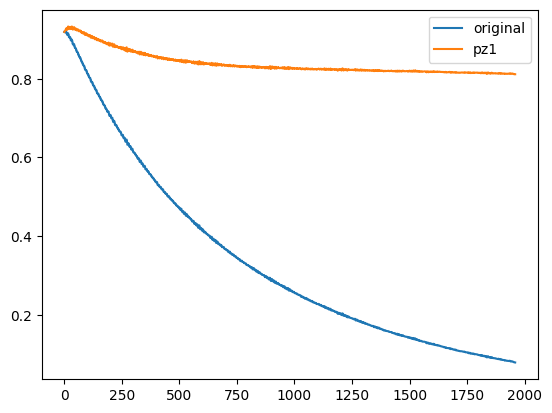

In [126]:
slice = super_wf_blsub[1040:3000]
pz1_slice = np.zeros(len(slice))
polezero(slice, 0.0018, pz1_slice)
plt.plot(slice, label="original")
plt.plot(pz1_slice, label="pz1")
plt.legend()
#plt.yscale('log')

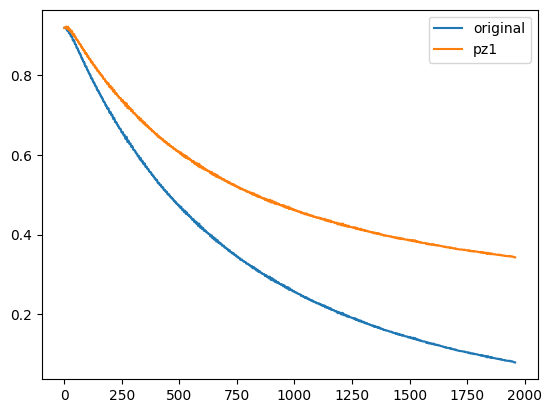

In [118]:
plt.plot(slice, label="original")
plt.plot(pz1_slice, label="pz1")
plt.legend()
#plt.yscale('log')
